# Getting Started
#### Imports
We make use of Python 3 along with a few imported libraries: 
- <a href="https://pandas.pydata.org/pandas-docs/stable/">pandas</a> and <a href="https://numpy.org/">numpy</a> to organize our data
- <a href="https://matplotlib.org/">matplotlib</a> and <a href="https://seaborn.pydata.org/">seaborn</a> to visualize our data
- <a href="https://scikit-learn.org/stable/">sklearn</a> to create models and make predictions based on our data
- <a href="https://spotipy.readthedocs.io/en/latest/">spotipy</a>, which we will go into more below.
- <a href="https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html">IPython</a> to help make our dataframes pretty while printing mid-cell

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from sklearn import tree, ensemble, neighbors, model_selection, metrics
from sklearn import tree, ensemble, neighbors, model_selection, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

#### Authorization
Spotipy is really cool! It enables us to gain access to the spotify API and use it in a more "pythonic" way (simply put, easier for us to use in python). Once we went on the Spotify website and apply for access to the API, we used the ID and Secret ID given to us in our authorization code below, so we can gain access to the API and parse through any data we use.

In [3]:
sb.set()

sp = spotipy.Spotify()
        
cid = "6d49981d346842a1844ab1612afae8ba"
csec = "e33407ff688c4d48908d5f5286fe8e41"


client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=csec)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Data Collection and Processing
### Creating Playlists
Now we get to the actual data collection process. As soon as we started this project, we hit the question: "How are we going to get the data on every grammy winner and nominee for the past 20 years?"

Obviously there's no "Grammy" section on Spotify, so we decided to cheat a little bit. Every song, album, user, and playlist has a specific ID within Spotify called its URI, which can easily be found through the settings of whatever page you are on. The important part here is that each playlist has its own ID, so we made our own playlists containing all the data we need!

We created playlists for the winners and the nominees of the past 20 years for Song of the Year, Album of the Year, and Best New Artist. With these playlists, we can access all the data we want much faster, instead of having to manually go through every song that we want.

### What data do we actually want?
Let's start with Song of the Year. In spotify, they assign numerical float values to each song's characteristics. Listed below are the values we are going to retrieve for each song, descriptions retrieved from the <a href="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/">Spotify API</a>.
- Name: Name of the song
- Release Date: Release date of the song
- Popularity: How "popular" is the song compared to other songs currently
- Danceability: How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 
- Energy: Measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 
- Loudness: The overall loudness of the track in decibals
- Speechiness: The presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- Acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 
- Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- Valence: 	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- Tempo: The overall estimated tempo of a track in beats per minute (BPM).

We also keep track of if a particular song won or lost in the year that it was nominated. The ideology here is that we use a song's characteristics and find patterns between the ones who won and the ones who lost using Machine Learning, in order to potentially predict this year's winners.

Finally, we create a dataframe to store all of this data. Keep in mind that Spotify API calls take a bit of time, especially when you run it on hundreds of songs (album of the year has over 500 songs, each with a lot of data to parse through), so we exported our dataframe to a CSV file immediately so accessing the data would be easier and we only need to run this code once.

In [3]:
#Access the playlist for song of the year winners for the past 20 years using the URI of the user (Tomi Olusina) 
#who made it and the playlist URI
playlist_tracks = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '7pF07PQEdD4e0AEoo6ue9G', fields='items,uri,name,id,total', market='fr')

#Create arrays for every category in our dataframe
name = []
date = []
pop = []
dance = []
energy = []
loud = []
speech = []
acous = []
live = []
valence = []
tempo = []
win = []

#Parse through the playlist data and add the values we are looking for for every song in the playlist
for i in playlist_tracks['items']:
    name.append(i['track']['name'])
    date.append(i['track']['album']['release_date'])
    pop.append(i['track']['popularity'])
    dance.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['danceability'])
    energy.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['energy'])
    loud.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['loudness'])
    speech.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['speechiness'])
    acous.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['acousticness'])
    live.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['liveness'])
    valence.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['valence'])
    tempo.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['tempo'])
    win.append(1)
    
#Now access the nominees for song of the year for the past 20 years and repeat the same process
playlist_tracks = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '4OzkYLxp0VzMNlYBXq2faU', fields='items,uri,name,id,total', market='fr')
for i in playlist_tracks['items']:
    name.append(i['track']['name'])
    date.append(i['track']['album']['release_date'])
    pop.append(i['track']['popularity'])
    dance.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['danceability'])
    energy.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['energy'])
    loud.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['loudness'])
    speech.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['speechiness'])
    acous.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['acousticness'])
    live.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['liveness'])
    valence.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['valence'])
    tempo.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['tempo'])
    win.append(0)

#Create a dataframe and add all the columns made
songdata = pd.DataFrame()
songdata.insert(0, "Name", name, True)
songdata.insert(1, "Date Released", date, True)
songdata.insert(2, "Popularity", pop, True)
songdata.insert(3, "Danceability", dance, True)
songdata.insert(4, "Energy", energy, True)
songdata.insert(5, "Loudness", loud, True)
songdata.insert(6, "Speechiness", speech, True)
songdata.insert(7, "Acousticness", acous, True)
songdata.insert(8, "Liveness", live, True)
songdata.insert(9, "Valence", valence, True)
songdata.insert(10, "Tempo", tempo, True)
songdata.insert(11, "Did They Win?", win, True)

#Send it to a CSV file
songdata
songdata.to_csv('topsongs.csv', encoding='utf-8', index=False)

In [4]:
songdb = pd.read_csv("topsongs.csv")
songdb

,Name,Date Released,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo,Did They Win?
0,Single Ladies (Put a Ring on It),2008-11-14,71,0.426,0.584,-5.293,0.2960,0.03830,0.1880,0.272,193.437,1
1,Need You Now,2010-01-01,69,0.587,0.622,-5.535,0.0303,0.09270,0.2000,0.231,107.943,1
2,Rolling in the Deep,2011-01-19,77,0.730,0.770,-5.114,0.0298,0.13800,0.0473,0.507,104.948,1
3,We Are Young (feat. Janelle Monáe),2012-02-14,76,0.378,0.638,-5.576,0.0750,0.02000,0.0849,0.735,184.086,1
4,Royals,2013-01-01,79,0.674,0.428,-9.504,0.1220,0.12100,0.1320,0.337,84.878,1
...,...,...,...,...,...,...,...,...,...,...,...,...
98,Umbrella,2008-06-02,81,0.583,0.829,-4.603,0.1340,0.00864,0.0426,0.575,174.028,0
99,American Boy,2008-03-28,80,0.727,0.729,-2.990,0.3260,0.17100,0.0700,0.512,117.932,0
100,Chasing Pavements,2008-01-28,68,0.614,0.470,-6.090,0.0255,0.29100,0.1110,0.329,80.045,0
101,I'm Yours,2008-05-12,84,0.686,0.457,-8.322,0.0468,0.59500,0.1050,0.718,150.953,0


### Album of the Year
Now we move to Album of the Year nominees and winners of the past 20 years. Obviously, you can't make a playlist of albums, so the workaround we created was simply creating playlists from one song from each album. From there, we could access the album's URI in the song's data, and use that URI to get all the data we need.

The data collection process here is very similar, but there is one slight difference. The song's characteristics like danceability and energy are only applicable to songs, not albums in the Spotify API. Therefore, to get the characteristics of an album, we take these characteristics and average them over all the songs in the album. For example, we get the danceability of an album by averaging the danceabilities of every song in the album.

Also, there was a bug in the data with one of the Taylor Swift albums and its URI, so we manually put in its URI and Name. Who knew she could be so problematic?

In [ ]:
#Get the songs for the winners once again from the playlist we made
playlist_albums = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '3q7RrjHTPcG1pAL3j4QcJF', fields='items,uri,name,id,total', market='fr')
playlist_albums

#smh Taylor
albums = ['2dqn5yOQWdyGwOpOIi9O4x']
name = ['Fearless']
date = []
pop = []
dance = []
energy = []
loud = []
speech = []
acous = []
live = []
valence = []
tempo = []
win = []

#Populate the name/date/popularity arrays now since that data is accessible, and get a list of the album URIs
for i in playlist_albums['items']:
    name.append(i['track']['album']['name'])
    date.append(i['track']['album']['release_date'])
    pop.append(i['track']['popularity'])
    win.append(1)
    albums.append(i['track']['album']['id'])

#Again, smh Taylor
del albums[1]
del name[1]

danceavg = 0
energyavg = 0
loudavg = 0
speechavg = 0
acousavg = 0
liveavg = 0
valenceavg = 0
tempoavg = 0
count = 0

#Go through each album, and get the avaerage characteristics for each album
for a in albums:
    songs = sp.album_tracks(a)
    for i in songs['items']:
        danceavg = danceavg + sp.audio_features('spotify:track:'+i['id'])[0]['danceability']
        energyavg = energyavg + sp.audio_features('spotify:track:'+i['id'])[0]['energy']
        loudavg = loudavg + sp.audio_features('spotify:track:'+i['id'])[0]['loudness']
        speechavg = speechavg + sp.audio_features('spotify:track:'+i['id'])[0]['speechiness']
        acousavg = acousavg + sp.audio_features('spotify:track:'+i['id'])[0]['acousticness']
        liveavg = liveavg + sp.audio_features('spotify:track:'+i['id'])[0]['liveness']
        valenceavg = valenceavg + sp.audio_features('spotify:track:'+i['id'])[0]['valence']
        tempoavg = tempoavg + sp.audio_features('spotify:track:'+i['id'])[0]['tempo']
        count = count + 1
    dance.append(danceavg/count)
    energy.append(energyavg/count)
    loud.append(loudavg/count)
    speech.append(speechavg/count)
    acous.append(acousavg/count)
    live.append(liveavg/count)
    valence.append(valenceavg/count)
    tempo.append(tempoavg/count)
    danceavg = 0
    energyavg = 0
    loudavg = 0
    speechavg = 0
    acousavg = 0
    liveavg = 0
    valenceavg = 0
    tempoavg = 0
    count = 0
    
#Repeat the process for nominees
playlist_albums = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '6ua8ZJ16YFgCou0ecqPgdV', fields='items,uri,name,id,total', market='fr')
playlist_albums

albums = []

for i in playlist_albums['items']:
    name.append(i['track']['album']['name'])
    date.append(i['track']['album']['release_date'])
    pop.append(i['track']['popularity'])
    win.append(0)
    albums.append(i['track']['album']['id'])

danceavg = 0
energyavg = 0
loudavg = 0
speechavg = 0
acousavg = 0
liveavg = 0
valenceavg = 0
tempoavg = 0
count = 0

    
for a in albums:
    songs = sp.album_tracks(a)
    for i in songs['items']:
        danceavg = danceavg + sp.audio_features('spotify:track:'+i['id'])[0]['danceability']
        energyavg = energyavg + sp.audio_features('spotify:track:'+i['id'])[0]['energy']
        loudavg = loudavg + sp.audio_features('spotify:track:'+i['id'])[0]['loudness']
        speechavg = speechavg + sp.audio_features('spotify:track:'+i['id'])[0]['speechiness']
        acousavg = acousavg + sp.audio_features('spotify:track:'+i['id'])[0]['acousticness']
        liveavg = liveavg + sp.audio_features('spotify:track:'+i['id'])[0]['liveness']
        valenceavg = valenceavg + sp.audio_features('spotify:track:'+i['id'])[0]['valence']
        tempoavg = tempoavg + sp.audio_features('spotify:track:'+i['id'])[0]['tempo']
        count = count + 1
    dance.append(danceavg/count)
    energy.append(energyavg/count)
    loud.append(loudavg/count)
    speech.append(speechavg/count)
    acous.append(acousavg/count)
    live.append(liveavg/count)
    valence.append(valenceavg/count)
    tempo.append(tempoavg/count)
    danceavg = 0
    energyavg = 0
    loudavg = 0
    speechavg = 0
    acousavg = 0
    liveavg = 0
    valenceavg = 0
    tempoavg = 0
    count = 0

albumdata = pd.DataFrame()
albumdata.insert(0, "Name", name, True)
albumdata.insert(1, "Date Released", date, True)
albumdata.insert(2, "Popularity", pop, True)
albumdata.insert(3, "Danceability", dance, True)
albumdata.insert(4, "Energy", energy, True)
albumdata.insert(5, "Loudness", loud, True)
albumdata.insert(6, "Speechiness", speech, True)
albumdata.insert(7, "Acousticness", acous, True)
albumdata.insert(8, "Liveness", live, True)
albumdata.insert(9, "Valence", valence, True)
albumdata.insert(10, "Tempo", tempo, True)
albumdata.insert(11, "Did They Win?", win, True)

albumdata
albumdata.to_csv('topalbums.csv', encoding='utf-8', index=False)

In [5]:
albumdb = pd.read_csv("topalbums.csv")
albumdb

,Name,Date Released,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo,Did They Win?
0,Fearless,2008-11-10,60,0.592769,0.637308,-5.276000,0.032992,0.175937,0.145554,0.384231,113.235462,1
1,The Suburbs,2010,71,0.448625,0.721381,-7.534563,0.045250,0.217593,0.205238,0.418344,127.591062,1
2,21,2011-01-19,77,0.581091,0.534091,-6.081727,0.036018,0.439371,0.117536,0.414636,133.496909,1
3,Babel,2012-09-21,52,0.404250,0.558167,-8.333750,0.038817,0.185863,0.127025,0.281533,116.001083,1
4,Random Access Memories,2013-05-17,64,0.686462,0.585846,-10.704077,0.044315,0.287906,0.132877,0.488231,114.471077,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99,These Days,2006-01-01,14,0.586674,0.567860,-7.979581,0.031730,0.485630,0.165735,0.530228,121.711581,0
100,In Rainbows,2007-12-28,61,0.529400,0.591700,-8.693000,0.038340,0.460245,0.093220,0.394620,121.130400,0
101,Tha Carter III,2008-01-01,75,0.679063,0.580375,-8.258250,0.225844,0.091419,0.258544,0.525188,125.076688,0
102,Viva La Vida or Death and All His Friends,2008-05-26,80,0.319700,0.658000,-8.284900,0.038630,0.115038,0.208800,0.261720,126.567200,0


### Best New Artist
Finally, we get the data for best new artist. Our workaround here was to simply make playlists with any song from the artist, then use that song to get the artist's URI to work with.

The data collection process is very similar once again, but there is much less data to work with in the Spotify API for this award. We simply retrieved the artist's name, number of followers, and popularity to make models and predictions for this award.

In [5]:
#Same process as before, just use the song's data from the playlist to access the artist's data
#This is easier here because artist data is also included within the original playlist's data
playlist_artists = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '6Wu1dIW3n13jsx0WoODnlQ', fields='items,uri,name,id,total', market='fr')
playlist_artists

name = []
followers = []
pop = []
win = []

for i in playlist_artists['items']:
    name.append(i['track']['album']['artists'][0]['name'])
    artist = sp.artist(i['track']['album']['artists'][0]['id'])
    followers.append(artist['followers']['total'])
    pop.append(artist['popularity'])
    win.append(1)
    
playlist_artists = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '6ua8ZJ16YFgCou0ecqPgdV', fields='items,uri,name,id,total', market='fr')
playlist_artists

for i in playlist_artists['items']:
    name.append(i['track']['album']['artists'][0]['name'])
    artist = sp.artist(i['track']['album']['artists'][0]['id'])
    followers.append(artist['followers']['total'])
    pop.append(artist['popularity'])
    win.append(0) 

    
artistdata = pd.DataFrame()
artistdata.insert(0, "Name", name, True)
artistdata.insert(1, "Followers", followers, True)
artistdata.insert(2, "Popularity", pop, True)
artistdata.insert(3, "Did They Win", win, True)

artistdata.to_csv('topartists.csv', encoding='utf-8', index=False)


In [6]:
artistdb = pd.read_csv("topartists.csv")
artistdb

,Name,Followers,Popularity,Did They Win
0,Zac Brown Band,1874027,77,1
1,Esperanza Spalding,236041,62,1
2,Bon Iver,2490997,79,1
3,fun.,3313046,73,1
4,Macklemore & Ryan Lewis,2424691,78,1
...,...,...,...,...
98,Vince Gill,284995,66,0
99,Radiohead,4742554,82,0
100,Lil Wayne,8506468,91,0
101,Coldplay,23419831,93,0


### Current Nominees

We aren't done yet! We need to create these same 3 dataframes, but for the current nominees for each award. The data collection process is similar once again, so it is reproduced below.

In [4]:

playlist_tracks = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '7InjGr6kiABbxyV5q9GPW1', fields='items,uri,name,id,total', market='fr')

name = []
date = []
pop = []
dance = []
energy = []
loud = []
speech = []
acous = []
live = []
valence = []
tempo = []

for i in playlist_tracks['items']:
    name.append(i['track']['name'])
    date.append(i['track']['album']['release_date'])
    pop.append(i['track']['popularity'])
    dance.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['danceability'])
    energy.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['energy'])
    loud.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['loudness'])
    speech.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['speechiness'])
    acous.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['acousticness'])
    live.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['liveness'])
    valence.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['valence'])
    tempo.append(sp.audio_features('spotify:track:'+i['track']['id'])[0]['tempo'])

songdata = pd.DataFrame()
songdata.insert(0, "Name", name, True)
songdata.insert(1, "Date Released", date, True)
songdata.insert(2, "Popularity", pop, True)
songdata.insert(3, "Danceability", dance, True)
songdata.insert(4, "Energy", energy, True)
songdata.insert(5, "Loudness", loud, True)
songdata.insert(6, "Speechiness", speech, True)
songdata.insert(7, "Acousticness", acous, True)
songdata.insert(8, "Liveness", live, True)
songdata.insert(9, "Valence", valence, True)
songdata.insert(10, "Tempo", tempo, True)

songdata
songdata.to_csv('2020songs.csv', encoding='utf-8', index=False)

In [7]:
songdb2 = pd.read_csv("2020songs.csv")
songdb2

,Name,Date Released,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo
0,Always Remember Us This Way,2018-10-05,82,0.553,0.502,-5.972,0.0409,0.299,0.7640,0.296,129.976
1,bad guy,2019-03-29,96,0.701,0.425,-10.965,0.3750,0.328,0.1000,0.562,135.128
2,Bring My Flowers Now,2019-08-23,42,0.557,0.198,-9.911,0.0461,0.948,0.2170,0.336,133.823
3,Hard Place,2018-11-02,70,0.614,0.719,-4.694,0.0955,0.179,0.1630,0.340,160.075
4,Lover,2019-08-23,88,0.359,0.543,-7.582,0.0919,0.492,0.1180,0.453,68.534
5,Norman fucking Rockwell,2019-08-30,77,0.218,0.215,-12.490,0.0368,0.967,0.0948,0.138,76.740
6,Someone You Loved,2019-05-17,96,0.501,0.405,-5.679,0.0319,0.751,0.1050,0.446,109.891
7,Truth Hurts,2019-05-03,91,0.715,0.624,-3.046,0.1140,0.110,0.1230,0.412,158.087


In [ ]:
playlist_albums = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '3uMdi0Gvd3rEp2aiWjy5jM', fields='items,uri,name,id,total', market='fr')
playlist_albums

albums = []
name = []
date = []
pop = []
dance = []
energy = []
loud = []
speech = []
acous = []
live = []
valence = []
tempo = []

for i in playlist_albums['items']:
    name.append(i['track']['album']['name'])
    date.append(i['track']['album']['release_date'])
    pop.append(i['track']['popularity'])
    albums.append(i['track']['album']['id'])

danceavg = 0
energyavg = 0
loudavg = 0
speechavg = 0
acousavg = 0
liveavg = 0
valenceavg = 0
tempoavg = 0
count = 0

for a in albums:
    songs = sp.album_tracks(a)
    for i in songs['items']:
        danceavg = danceavg + sp.audio_features('spotify:track:'+i['id'])[0]['danceability']
        energyavg = energyavg + sp.audio_features('spotify:track:'+i['id'])[0]['energy']
        loudavg = loudavg + sp.audio_features('spotify:track:'+i['id'])[0]['loudness']
        speechavg = speechavg + sp.audio_features('spotify:track:'+i['id'])[0]['speechiness']
        acousavg = acousavg + sp.audio_features('spotify:track:'+i['id'])[0]['acousticness']
        liveavg = liveavg + sp.audio_features('spotify:track:'+i['id'])[0]['liveness']
        valenceavg = valenceavg + sp.audio_features('spotify:track:'+i['id'])[0]['valence']
        tempoavg = tempoavg + sp.audio_features('spotify:track:'+i['id'])[0]['tempo']
        count = count + 1
    dance.append(danceavg/count)
    energy.append(energyavg/count)
    loud.append(loudavg/count)
    speech.append(speechavg/count)
    acous.append(acousavg/count)
    live.append(liveavg/count)
    valence.append(valenceavg/count)
    tempo.append(tempoavg/count)
    danceavg = 0
    energyavg = 0
    loudavg = 0
    speechavg = 0
    acousavg = 0
    liveavg = 0
    valenceavg = 0
    tempoavg = 0
    count = 0
    

albumdata = pd.DataFrame()
albumdata.insert(0, "Name", name, True)
albumdata.insert(1, "Date Released", date, True)
albumdata.insert(2, "Popularity", pop, True)
albumdata.insert(3, "Danceability", dance, True)
albumdata.insert(4, "Energy", energy, True)
albumdata.insert(5, "Loudness", loud, True)
albumdata.insert(6, "Speechiness", speech, True)
albumdata.insert(7, "Acousticness", acous, True)
albumdata.insert(8, "Liveness", live, True)
albumdata.insert(9, "Valence", valence, True)
albumdata.insert(10, "Tempo", tempo, True)

albumdata
albumdata.to_csv('2020albums.csv', encoding='utf-8', index=False)

In [8]:
albumdb2 = pd.read_csv("2020albums.csv")
albumdb2

,Name,Date Released,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo
0,"i,i",2019-08-09,58,0.465231,0.324862,-12.271923,0.098315,0.875923,0.239092,0.249631,106.955769
1,Norman Fucking Rockwell!,2019-08-30,77,0.434214,0.271457,-11.989429,0.042664,0.823000,0.120293,0.228979,97.773857
2,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2019-03-29,96,0.583786,0.281721,-15.085071,0.193086,0.656857,0.239307,0.288007,105.494286
3,"thank u, next",2019-02-08,89,0.668250,0.525583,-6.622000,0.141642,0.298733,0.154742,0.388917,113.231167
4,I Used To Know Her,2019-08-30,60,0.549263,0.492421,-9.299053,0.165763,0.471753,0.167553,0.370826,107.297263
5,7 EP,2019-06-21,88,0.751500,0.586625,-6.646625,0.110963,0.152750,0.158362,0.531375,142.742375
6,Cuz I Love You,2019-04-19,67,0.706818,0.731545,-4.324364,0.129882,0.051543,0.304291,0.631727,127.846545
7,Father of the Bride,2019-05-03,62,0.642389,0.504167,-7.761889,0.062189,0.522978,0.168917,0.527778,118.150222


In [10]:
playlist_artists = sp.user_playlist_tracks('22b7g6udnfkubfplnsla3ww5a', '5Ihltik64Mn9LOlhgya8UE', fields='items,uri,name,id,total', market='fr')
playlist_artists

name = []
followers = []
pop = []

for i in playlist_artists['items']:
    name.append(i['track']['album']['artists'][0]['name'])
    artist = sp.artist(i['track']['album']['artists'][0]['id'])
    followers.append(artist['followers']['total'])
    pop.append(artist['popularity'])

    
artistdata = pd.DataFrame()
artistdata.insert(0, "Name", name, True)
artistdata.insert(1, "Followers", followers, True)
artistdata.insert(2, "Popularity", pop, True)

artistdata
artistdata.to_csv('2020artists.csv', encoding='utf-8', index=False)

In [9]:
artistdb2 = pd.read_csv("2020artists.csv")
artistdb2

,Name,Followers,Popularity
0,Black Pumas,71329,61
1,Billie Eilish,17055834,98
2,Lil Nas X,1900496,87
3,Lizzo,1602632,88
4,Maggie Rogers,509106,76
5,ROSALÍA,1970207,85
6,Tank and The Bangas,115219,50
7,Yola,26757,54


### Now that we have our data...

Let's create our own function to help later on when displaying the data. This function below will take in two data entries and plot them overlapping on a <a href="https://www.data-to-viz.com/caveat/spider.html">radar graph, also known as a spider chart</a>. Pretty cool!

In [1]:
def radar_graphs(labels, stats, stats2, title):
    # Radar graphs
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    stats2=np.concatenate((stats2,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, c="Blue")
    ax.fill(angles, stats, alpha=0.25, c="Blue")
    ax.plot(angles, stats2, 'o-', linewidth=2, c="Yellow")
    ax.fill(angles, stats2, alpha=0.25, fc="Yellow")
    ax.set_thetagrids(angles * 180/np.pi, labels)
    plt.ylim(0,1)
    ax.set_title(title)
    ax.grid(True)

# Data Analysis

Like we mentioned above, querying an API for every nomination across three categories over the past twenty years takes *a lot* of time! So what we did was we made it easy for everyone to use the same data through exporting the data to csv files once, and reading directly from the file for the remainder of the time! Just only run the cells from this point onward to save yourself some time.

In [2]:
songdb = pd.read_csv("topsongs.csv")
albumdb = pd.read_csv("topalbums.csv")
artistdb = pd.read_csv("topartists.csv")

nominations_songdb_2020 = pd.read_csv("2020songs.csv")
nominations_albumdb_2020 = pd.read_csv("2020albums.csv")
nominations_artistdb_2020 = pd.read_csv("2020artists.csv")

## First up...

Best new artist is the first category that we predicted. We only found two distinguishing parameters: followers and popularity. Followers was based off of spotify, and popularity is calculated using a proprietary algorithm that spotify employs scaling from 1 to 100. 

In [3]:
artistdb

,Name,Followers,Popularity,Did They Win
0,Zac Brown Band,1874027,77,1
1,Esperanza Spalding,236041,62,1
2,Bon Iver,2490997,79,1
3,fun.,3313046,73,1
4,Macklemore & Ryan Lewis,2424691,78,1
...,...,...,...,...
98,Vince Gill,284995,66,0
99,Radiohead,4742554,82,0
100,Lil Wayne,8506468,91,0
101,Coldplay,23419831,93,0


Let's dive into using our data. We first wanted to see if we can predict the best new artist using our model, by using the historic data! We couldn't find a ton of data about each artist besides their follower count and popularity, so we ran with what we got and trained using a 90-10% split and compared the results to the actuals.

In [4]:
# Top artist predictions
artist_data = artistdb.copy().iloc[:,1:-1]

# Need to divide followers by a large number so the program won't hang when training due to large numbers
artist_data['Followers'] = artist_data['Followers']/10000
artist_target = artistdb.copy().iloc[:,-1:]
# artist_data

# Splits the data and target datasets into training and testing. Uses random seed to pick and choose data
X_train, X_test, y_train, y_test = train_test_split(artist_data, artist_target, test_size=0.1, random_state=11)

dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train, y_train.values.ravel())
# tree.plot_tree(dt_clf.fit(song_data, song_target.values.ravel())) 

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.values.ravel())

rfc = ensemble.RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train.values.ravel())

display(X_test)

# Tests output with remaining 10%
print("decision tree: \t\t" + str(dt_clf.predict(np.c_[X_test])))
print("k nearest neighbors: \t" + str(knn.predict(np.c_[X_test])))
print("random forest: \t\t" + str(rfc.predict(np.c_[X_test])))

,Followers,Popularity
100,850.6468,91
51,4285.7990,98
42,1076.2405,92
85,728.2066,84
15,2119.6395,93
58,36.7546,70
16,476.9834,85
92,851.7211,83
36,131.0488,76
30,3531.4708,91


decision tree: 		[0 0 1 1 0 0 1 0 0 1 0]
k nearest neighbors: 	[0 0 0 0 0 0 0 0 0 0 0]
random forest: 		[0 0 1 1 0 0 1 0 0 0 0]


In the above example, the names of artists were take out to train the model but the index number still remains so we can look the artists up. In this case (and for other awards), indices <= 19 are the winners, and the remainder are nonwinners. With this particular 9:1 split, our models predicted 1 of the 2 winners that were present in the dataset.

### Our artist prediction

To do this prediction, we trained a decision tree, k-nearest neighbors, and a random forest classifier using the entire artist nominee dataset from the past 20 years. Our models had pretty much a three-way tie between Black Pumas, Tank and Tha Bangas, and Yola: all three artists that have a lower popularity and a relatively low number of followers. Have you heard of them?

A bit more about the models we used could be found here: 
- DT: https://scikit-learn.org/stable/modules/tree.html
- KNN: https://scikit-learn.org/stable/modules/neighbors.html
- Random Forest: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [5]:
# Artist Predictions
# Refits using 100% of data and runs model on current year nominees to get predictions for winners

dt_clf.fit(artist_data, artist_target.values.ravel())
knn.fit(artist_data, artist_target.values.ravel())
rfc.fit(artist_data, artist_target.values.ravel())

display(nominations_artistdb_2020)
artist_data_2020 = nominations_artistdb_2020.iloc[:,1:]
artist_data_2020['Followers'] = artist_data_2020['Followers']/10000

print("decision tree: \t\t" + str(dt_clf.predict(np.c_[artist_data_2020])))
print("k nearest neighbors: \t" + str(knn.predict(np.c_[artist_data_2020])))
print("random forest: \t\t" + str(rfc.predict(np.c_[artist_data_2020])))

,Name,Followers,Popularity
0,Black Pumas,71329,61
1,Billie Eilish,17055834,98
2,Lil Nas X,1900496,87
3,Lizzo,1602632,88
4,Maggie Rogers,509106,76
5,ROSALÍA,1970207,85
6,Tank and The Bangas,115219,50
7,Yola,26757,54


decision tree: 		[1 0 0 0 0 1 1 1]
k nearest neighbors: 	[0 0 0 0 0 0 0 0]
random forest: 		[1 0 0 0 0 0 1 1]


In each of the outputs of the models above a 1 stands for "win" and 0 means it did not win. Obviously, there cannot be more than one winner each year and sometimes models predict no winners (which can't happen), so what we did was as there was not a whole lot of data to train off of, we summed up the number of models that predicted a win for each artist and if there were ties, we were able to at least narrow down the field to the artists who we think have the best shot at winning.

## Song of The Year

The grammy award for song of the year is presented to a single or a track and goes towards the songwriter(s) who wrote the lyrics and melodies to the song. It judges the actual content behind the song itself, and not the recording.

For SOTY, we had a couple more parameters we could play around with: namely characteristics regarding the music itself. Once again we messed around and trained/tested the data using portions of the original dataset, and then we later on fitted the entire dataset to predict the new nominees. 

In [6]:
songdb

,Name,Date Released,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo,Did They Win?
0,Single Ladies (Put a Ring on It),2008-11-14,71,0.426,0.584,-5.293,0.2960,0.03830,0.1880,0.272,193.437,1
1,Need You Now,2010-01-01,69,0.587,0.622,-5.535,0.0303,0.09270,0.2000,0.231,107.943,1
2,Rolling in the Deep,2011-01-19,77,0.730,0.770,-5.114,0.0298,0.13800,0.0473,0.507,104.948,1
3,We Are Young (feat. Janelle Monáe),2012-02-14,76,0.378,0.638,-5.576,0.0750,0.02000,0.0849,0.735,184.086,1
4,Royals,2013-01-01,79,0.674,0.428,-9.504,0.1220,0.12100,0.1320,0.337,84.878,1
...,...,...,...,...,...,...,...,...,...,...,...,...
98,Umbrella,2008-06-02,81,0.583,0.829,-4.603,0.1340,0.00864,0.0426,0.575,174.028,0
99,American Boy,2008-03-28,80,0.727,0.729,-2.990,0.3260,0.17100,0.0700,0.512,117.932,0
100,Chasing Pavements,2008-01-28,68,0.614,0.470,-6.090,0.0255,0.29100,0.1110,0.329,80.045,0
101,I'm Yours,2008-05-12,84,0.686,0.457,-8.322,0.0468,0.59500,0.1050,0.718,150.953,0


Once again (like artists), we did experimentation with our models to see if they could actually predict winners. We did a 9:1 train/test split on the historical data using the three models outlined above. In the results below, row keys < 20 are historical winners.

In [7]:
# Best Song testing/training
print("Best song testing/training using 9:1")
# Splits the dataset into the parameters and the target
song_data = songdb.copy().iloc[:,2:-1]
song_target = songdb.copy().iloc[:,-1:]

# Splits the data and target datasets into training and testing, at 9:1 split. Uses random seed to pick and choose data
X_train, X_test, y_train, y_test = train_test_split(song_data, song_target, test_size=0.1, random_state=61)
display(X_test)

# Fits decision tree and other models using 90% of data
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train, y_train.values.ravel())
# tree.plot_tree(dt_clf.fit(X_train, y_train.values.ravel())) 

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.values.ravel())

rfc = ensemble.RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train.values.ravel())

# Tests output with remaining 10%
print("decision tree: \t\t" + str(dt_clf.predict(np.c_[X_test])))
print("k nearest neighbors: \t" + str(knn.predict(np.c_[X_test])))
print("random forest: \t\t" + str(rfc.predict(np.c_[X_test])))

Best song testing/training using 9:1


,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo
9,78,0.854,0.463,-6.159,0.1370,0.1170,0.3540,0.549,120.024
37,79,0.726,0.698,-4.165,0.0431,0.0490,0.3090,0.867,143.994
31,67,0.379,0.306,-14.446,0.0305,0.9420,0.1230,0.157,147.902
17,64,0.425,0.554,-4.145,0.0298,0.1340,0.0963,0.288,83.917
20,77,0.851,0.806,-4.620,0.0787,0.1180,0.1210,0.787,118.999
11,74,0.536,0.928,-6.492,0.0589,0.0154,0.2000,0.389,136.258
0,71,0.426,0.584,-5.293,0.2960,0.0383,0.1880,0.272,193.437
1,69,0.587,0.622,-5.535,0.0303,0.0927,0.2000,0.231,107.943
89,40,0.638,0.443,-6.860,0.0283,0.3740,0.5470,0.556,111.079
55,83,0.620,0.574,-7.788,0.0479,0.5700,0.1900,0.352,100.021


decision tree: 		[0 0 0 1 0 0 1 0 0 0 1]
k nearest neighbors: 	[0 0 0 0 0 0 0 0 0 0 0]
random forest: 		[0 0 0 0 0 0 0 0 0 0 0]


### And the grammy for song of the year goes to...

To predict this, we fit all models with the entire historical data set from the past twenty years, and ran the model with this year's nominees

And for the results: the model is split between *bad guy* and *Someone You Loved*. Sometimes the model likes one over the other, and other times the model likes both. Looking at the popularity of both of those songs, those songs lead the popularity leaderboard for the nominees and are tied, which may explain why the model likes them both.



In [8]:
# Song Predictions
# Refits using 100% of data and runs model on current year nominees to get predictions for winners

print("Song predictions for 2020 Grammys")

dt_clf.fit(song_data, song_target.values.ravel())
knn.fit(song_data, song_target.values.ravel())
rfc.fit(song_data, song_target.values.ravel())

display(nominations_songdb_2020)
song_data_2020 = nominations_songdb_2020.iloc[:,2:]
print("decision tree: \t\t" + str(dt_clf.predict(np.c_[song_data_2020])))
print("k nearest neighbors: \t" + str(knn.predict(np.c_[song_data_2020])))
print("random forest: \t\t" + str(rfc.predict(np.c_[song_data_2020])))


Song predictions for 2020 Grammys


,Name,Date Released,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo
0,Always Remember Us This Way,2018-10-05,82,0.553,0.502,-5.972,0.0409,0.299,0.7640,0.296,129.976
1,bad guy,2019-03-29,96,0.701,0.425,-10.965,0.3750,0.328,0.1000,0.562,135.128
2,Bring My Flowers Now,2019-08-23,42,0.557,0.198,-9.911,0.0461,0.948,0.2170,0.336,133.823
3,Hard Place,2018-11-02,70,0.614,0.719,-4.694,0.0955,0.179,0.1630,0.340,160.075
4,Lover,2019-08-23,88,0.359,0.543,-7.582,0.0919,0.492,0.1180,0.453,68.534
5,Norman fucking Rockwell,2019-08-30,77,0.218,0.215,-12.490,0.0368,0.967,0.0948,0.138,76.740
6,Someone You Loved,2019-05-17,96,0.501,0.405,-5.679,0.0319,0.751,0.1050,0.446,109.891
7,Truth Hurts,2019-05-03,91,0.715,0.624,-3.046,0.1140,0.110,0.1230,0.412,158.087


decision tree: 		[0 1 0 0 0 0 1 0]
k nearest neighbors: 	[0 0 0 0 0 0 0 0]
random forest: 		[0 0 0 0 0 0 0 0]


## Album of the year

This award is the most prestigious awarded at the Grammys, and is presented to "honor artistic achievement, technical proficiency and overall excellence in the recording industry, without regard to album sales, chart position, or critical reception."

More info about the actual award can be found here: https://www.grammy.com/grammys/news/2020-grammy-awards-complete-nominees-list#general

In [9]:
albumdb

,Name,Date Released,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo,Did They Win?
0,Fearless,2008-11-10,60,0.592769,0.637308,-5.276000,0.032992,0.175937,0.145554,0.384231,113.235462,1
1,The Suburbs,2010,71,0.448625,0.721381,-7.534563,0.045250,0.217593,0.205238,0.418344,127.591062,1
2,21,2011-01-19,77,0.581091,0.534091,-6.081727,0.036018,0.439371,0.117536,0.414636,133.496909,1
3,Babel,2012-09-21,52,0.404250,0.558167,-8.333750,0.038817,0.185863,0.127025,0.281533,116.001083,1
4,Random Access Memories,2013-05-17,64,0.686462,0.585846,-10.704077,0.044315,0.287906,0.132877,0.488231,114.471077,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99,These Days,2006-01-01,14,0.586674,0.567860,-7.979581,0.031730,0.485630,0.165735,0.530228,121.711581,0
100,In Rainbows,2007-12-28,61,0.529400,0.591700,-8.693000,0.038340,0.460245,0.093220,0.394620,121.130400,0
101,Tha Carter III,2008-01-01,75,0.679063,0.580375,-8.258250,0.225844,0.091419,0.258544,0.525188,125.076688,0
102,Viva La Vida or Death and All His Friends,2008-05-26,80,0.319700,0.658000,-8.284900,0.038630,0.115038,0.208800,0.261720,126.567200,0


Once again, we did a similar testing/training method as with the other two categories. If you're just looking for our prediction for this year, skip ahead to the next subheading.

In [10]:
# Best Album testing/training
# Splits the dataset into the parameters and the target
album_data = albumdb.copy().iloc[:,2:-1]
album_target = albumdb.copy().iloc[:,-1:]

# Splits the data and target datasets into training and testing, at 9:1 split. Uses random seed to pick and choose data
X_train, X_test, y_train, y_test = train_test_split(album_data, album_target, test_size=0.1, random_state=112)
display(X_test)

# Fits decision tree and other models to the 90%
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train, y_train.values.ravel())

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.values.ravel())

rfc = ensemble.RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train.values.ravel())

# Prints results of testing these models to the 10%
print("decision tree: \t\t" + str(dt_clf.predict(np.c_[X_test])))
print("k nearest neighbors: \t" + str(knn.predict(np.c_[X_test])))
print("random forest: \t\t" + str(rfc.predict(np.c_[X_test])))

,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo
31,59,0.635167,0.777500,-4.503250,0.086367,0.111158,0.148217,0.532583,130.416833
0,60,0.592769,0.637308,-5.276000,0.032992,0.175937,0.145554,0.384231,113.235462
36,45,0.480000,0.699909,-6.064455,0.069155,0.146493,0.206618,0.484273,133.622455
19,23,0.484000,0.232450,-14.262300,0.040010,0.912700,0.106920,0.236500,110.599600
55,65,0.601900,0.747600,-6.427600,0.344500,0.294900,0.266620,0.557600,118.431000
99,14,0.586674,0.567860,-7.979581,0.031730,0.485630,0.165735,0.530228,121.711581
47,75,0.590750,0.707625,-5.802062,0.294175,0.322889,0.318419,0.487187,103.444563
56,61,0.589455,0.413818,-9.371091,0.079500,0.335828,0.113909,0.274909,102.875364
71,32,0.593786,0.496229,-11.337429,0.064086,0.544571,0.259050,0.485429,123.130714
89,57,0.707667,0.601278,-6.434556,0.104656,0.206316,0.136194,0.608222,112.228333


decision tree: 		[0 1 0 1 1 0 0 0 0 0 0]
k nearest neighbors: 	[0 0 0 0 0 0 0 0 1 0 0]
random forest: 		[0 0 0 0 0 0 0 0 0 0 0]


### And the winner is...

No thank you, next, it's Norman Fucking Rockwell! by Lana Del Rey *(please excuse the language, it's the actual name)*. Two models predicted that this album would come up first consistently, making it our pick for this year's winner.

In [11]:
# Best album predictions
# Refits using 100% of data and runs model on current year nominees to get predictions for winners

print("Album predictions for 2020 Grammys")

dt_clf.fit(album_data, album_target.values.ravel())
knn.fit(album_data, album_target.values.ravel())
rfc.fit(album_data, album_target.values.ravel())

display(nominations_albumdb_2020)
album_data_2020 = nominations_albumdb_2020.iloc[:,2:]
print("decision tree: \t\t" + str(dt_clf.predict(np.c_[album_data_2020])))
print("k nearest neighbors: \t"+ str(knn.predict(np.c_[album_data_2020])))
print("random forest: \t\t" + str(rfc.predict(np.c_[album_data_2020])))

Album predictions for 2020 Grammys


,Name,Date Released,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo
0,"i,i",2019-08-09,58,0.465231,0.324862,-12.271923,0.098315,0.875923,0.239092,0.249631,106.955769
1,Norman Fucking Rockwell!,2019-08-30,77,0.434214,0.271457,-11.989429,0.042664,0.823000,0.120293,0.228979,97.773857
2,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2019-03-29,96,0.583786,0.281721,-15.085071,0.193086,0.656857,0.239307,0.288007,105.494286
3,"thank u, next",2019-02-08,89,0.668250,0.525583,-6.622000,0.141642,0.298733,0.154742,0.388917,113.231167
4,I Used To Know Her,2019-08-30,60,0.549263,0.492421,-9.299053,0.165763,0.471753,0.167553,0.370826,107.297263
5,7 EP,2019-06-21,88,0.751500,0.586625,-6.646625,0.110963,0.152750,0.158362,0.531375,142.742375
6,Cuz I Love You,2019-04-19,67,0.706818,0.731545,-4.324364,0.129882,0.051543,0.304291,0.631727,127.846545
7,Father of the Bride,2019-05-03,62,0.642389,0.504167,-7.761889,0.062189,0.522978,0.168917,0.527778,118.150222


decision tree: 		[1 1 1 0 0 0 0 0]
k nearest neighbors: 	[0 0 0 0 0 0 0 0]
random forest: 		[0 1 0 0 0 0 0 0]


## What did the winners do different?

Surely there's no "formula" to win a grammy, but let's take a look at how the winners differentiated themselves, starting with Album of the Year. To do this, we calculated the means of the song characteristics of the winners and the nonwinners(nominees). We then displayed most of the data in a radar graph, and the complete dataset in a table. Some data points such as tempo, loudness, and popularity were unable to be displayed in the radar graph due to the fact they are not normalized to a 0-1 scale.

### AOTY

,Category,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo
0,Nominees,61.795181,0.601985,0.617797,-7.523622,0.122675,0.247663,0.198577,0.483581,118.622487
1,Winners,53.238095,0.561737,0.519176,-8.798392,0.055596,0.400329,0.143830,0.445964,118.141397


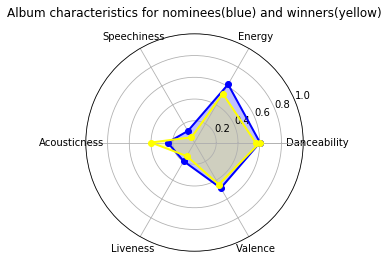

In [12]:
# Album characteristics
labels = np.array(['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Liveness', 'Valence'])
album_averages = albumdb.loc[:,labels].values.mean(axis=0)
album_winner_averages = albumdb.loc[albumdb['Did They Win?'] == 1,labels].values.mean(axis=0)
album_nominee_averages = albumdb.loc[albumdb['Did They Win?'] == 0,labels].values.mean(axis=0)

# Constructs table including info such as loudness and tempo
album_characteristics = pd.DataFrame([album_data.loc[album_target['Did They Win?'] == 0].values.mean(axis=0), album_data.loc[album_target['Did They Win?'] == 1].values.mean(axis=0)], columns = album_data.columns.values) 
album_characteristics.insert(0, 'Category', ["Nominees", "Winners"])

# Outputs
radar_graphs(labels, album_nominee_averages, album_winner_averages, "Album characteristics for nominees(blue) and winners(yellow)")
display(album_characteristics)


In this case, winning albums definitely weren't the most popular ones which leads us to believe that there are a ton of hidden gems out there that stand out during this award ceremony and their judging system truly does ignore chart position and focuses on the music itself. Winning albums tended to be less energetic and more quieter, while also being less wordy, less speechy, a little quieter, and definitely more acoustic. These might not be the albums to blast at parties, but instead may be albums that focus more on the artistic/creative aspect of music.

### SOTY

,Category,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo
0,Nominees,70.421687,0.60212,0.595964,-6.620506,0.077748,0.293924,0.168978,0.442589,119.906337
1,Winners,74.150000,0.59940,0.570750,-6.407150,0.060615,0.244627,0.157510,0.476050,114.108300


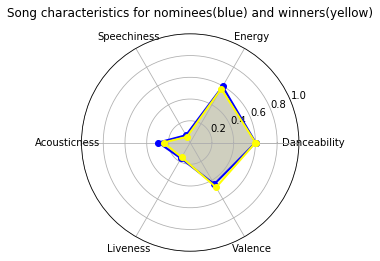

In [13]:
# Song characteristics

labels = np.array(['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Liveness', 'Valence'])
song_averages = songdb.loc[:,labels].values.mean(axis=0)
song_winner_averages = songdb.loc[songdb['Did They Win?'] == 1,labels].values.mean(axis=0)
song_nominee_averages = songdb.loc[songdb['Did They Win?'] == 0,labels].values.mean(axis=0)

# Constructs table including info such as loudness and tempo
song_characteristics = pd.DataFrame([song_data.loc[song_target['Did They Win?'] == 0].values.mean(axis=0), song_data.loc[song_target['Did They Win?'] == 1].values.mean(axis=0)], columns = song_data.columns.values) 
song_characteristics.insert(0, 'Category', ["Nominees", "Winners"])

# Outputs
radar_graphs(labels, song_nominee_averages, song_winner_averages, "Song characteristics for nominees(blue) and winners(yellow)")
display(song_characteristics)

SOTY ended up being quite different compared to AOTY. These winners tended to be the popular hits, with a good amount of loudness (especially compared to the albums as a whole). Otherwise, it is hard to distinguish what makes a winner a winner in this category through these metrics alone besides the difference in popularity. This may be because a big part of the SOTY category is judging the actual songwriting and lyrics themselves, which is something pretty hard to quantify and shows not a big relationship with these other metrics.